Reference
https://github.com/mitsuba-renderer/mitsuba3/blob/152352f87b5baea985511b2a80d9f91c3c945a90/include/mitsuba/core/vector.h

```
/// Complete the set {a} to an orthonormal basis {a, b, c}
template <typename Vector3f> std::pair<Vector3f, Vector3f> coordinate_system(const Vector3f &n) {
    static_assert(Vector3f::Size == 3, "coordinate_system() expects a 3D vector as input!");

    using Float = dr::value_t<Vector3f>;

    /* Based on "Building an Orthonormal Basis, Revisited" by
       Tom Duff, James Burgess, Per Christensen,
       Christophe Hery, Andrew Kensler, Max Liani,
       and Ryusuke Villemin (JCGT Vol 6, No 1, 2017) */

    Float sign = dr::sign(n.z()),
          a    = -dr::rcp(sign + n.z()),
          b    = n.x() * n.y() * a;

    return {
        Vector3f(dr::mulsign(dr::sqr(n.x()) * a, n.z()) + 1,
                 dr::mulsign(b, n.z()),
                 dr::mulsign_neg(n.x(), n.z())),
        Vector3f(b, dr::fmadd(n.y(), n.y() * a, sign), -n.y())
    };
}
```

# Implementation

In [1]:
import torch

def mulsign(v1, v2):
    """
    multiplies v1 by the sign of v2

    Code reference: https://github.com/mitsuba-renderer/drjit/blob/8b3cc94a6e638d8dfcc60065cd13fcc561386938/include/drjit/array_router.h

    Args:
        v1: tensor 
        v2: tensor
    Returns:
        v: tensor
    """

    v = torch.zeros_like(v1)
    v[:] = -v1
    v[v2>=0] = v1[v2>=0]
    return v

def mulsign_neg(v1, v2):
    """
    multiplies v1 by the sign of -v2

    Code reference: https://github.com/mitsuba-renderer/drjit/blob/8b3cc94a6e638d8dfcc60065cd13fcc561386938/include/drjit/array_router.h

    Args:
        v1: tensor 
        v2: tensor
    Returns:
        v: tensor
    """
    v = torch.zeros_like(v1)
    v[:] = v1
    v[v2>=0] = -v1[v2>=0]
    return v

def coordinate_system(z):
    """
    Compute the x and y coordinates of the input unit vectors z. 
    x, y, z consistute the orthonormal basis

    Code reference: https://github.com/mitsuba-renderer/mitsuba3/blob/152352f87b5baea985511b2a80d9f91c3c945a90/include/mitsuba/core/vector.h
    /* Based on "Building an Orthonormal Basis, Revisited" by
       Tom Duff, James Burgess, Per Christensen,
       Christophe Hery, Andrew Kensler, Max Liani,
       and Ryusuke Villemin (JCGT Vol 6, No 1, 2017) */

    Args:
        z: [N,3] unit vectors
    Returns:
        xy: [N,6] unit vectors
            x = xy[:,:3], y = xy[:,3:]
    """

    sign = torch.sign(z[:,2])
    a = -1/(sign + z[:,2])
    b = z[:,0] * z[:,1] * a

    x = torch.stack( [mulsign(((z[:,0])**2) * a, z[:,2]) + 1, mulsign(b, z[:,2]), mulsign_neg(z[:,0], z[:,2])], 1)
    y = torch.stack( [b, z[:,1]*(z[:,1]*a) + sign, -z[:,1]], 1)
    ret = torch.cat([x, y], 1)

    return ret

def stokes_basis(z):
    # https://github.com/mitsuba-renderer/mitsuba3/blob/9bd47c7600b9b2e16c8bc0b5b2266e5915587345/docs/src/key_topics/polarization.rst
    xy = coordinate_system(z)
    x = xy[:,:3]
    return x


# Testing

In [15]:
def branchless_onb(n):
    """
    Building an Orthonormal Basis, Revisited
    Tom Duff, James Burgess, Per Christensen, Christophe Hery,
    Andrew Kensler, Max Liani, and Ryusuke Villemin
    """
    sign = torch.copysign(torch.tensor(1.0), n[2])
    a = -1.0 / (sign + n[2])
    b = n[0] * n[1] * a
    return torch.tensor(
        [[1.0 + sign * n[0] * n[0] * a, sign * b, -sign * n[0]],
        [b, sign + n[1] * n[1] * a, -n[1]]]
    )

def square_to_uniform_sphere(sample):
    z = 1-2*sample[:,1]
    r = torch.sqrt(1-z**2)
    sinphi = torch.sin(2*torch.pi*sample[:,0])
    cosphi = torch.cos(2*torch.pi*sample[:,0])
    return torch.stack([r*cosphi, r*sinphi, z], 1)

a = [0.70710678, -0. , -0.70710678]
b = [-0.,  1.,  0.]
assert torch.allclose(
    branchless_onb([(0.5)**0.5, 0, (0.5)**0.5]), torch.tensor([a, b]), atol=1e-6)
assert torch.allclose(
    coordinate_system(torch.tensor([(0.5)**0.5, 0, (0.5)**0.5]).reshape(1,3)), torch.tensor([a, b]).reshape(1,6), atol=1e-6)

for u in torch.linspace(0, 1, 10):
    for v in torch.linspace(0, 1, 10):
        n = square_to_uniform_sphere(torch.tensor([u, v]).reshape(1,2))

        s1, t1 = branchless_onb(n.squeeze())
        st2 = coordinate_system(n.reshape(1,3))
        s2, t2 = st2[:,:3], st2[:,3:]
        assert torch.allclose(s1, s2, atol=1e-6)
        assert torch.allclose(t1, t2, atol=1e-6)

print('Testing succeeded!')

Testing succeeded!


# compute per-pixel Stokes coordinates on a camera coordinate 

(<AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7fbbb9121430>)

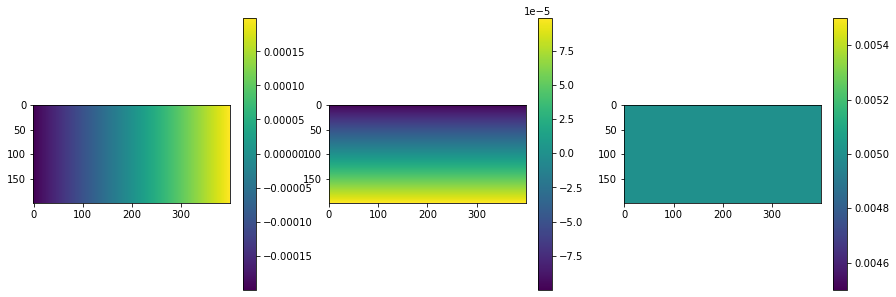

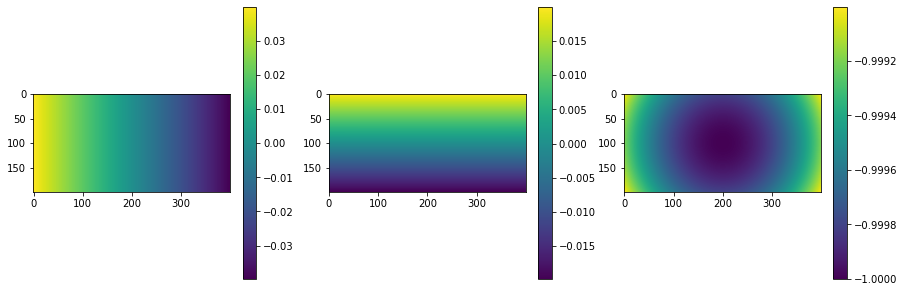

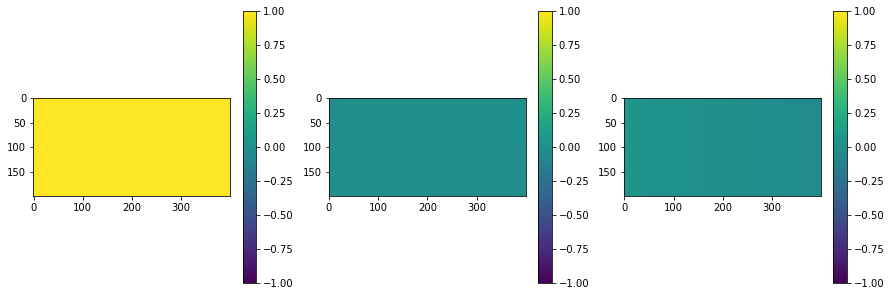

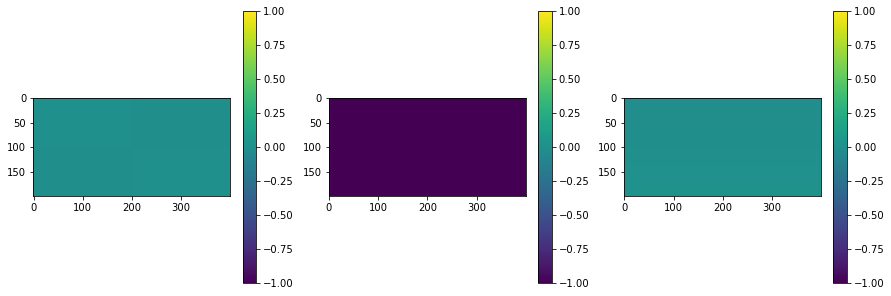

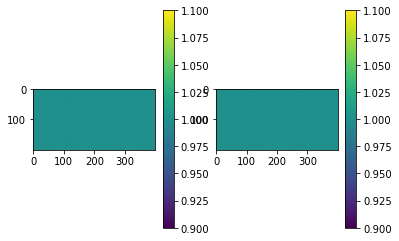

In [3]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# camera parameters
miny = -100*1e-6
maxy = 100*1e-6
minx = -200*1e-6
maxx = 200*1e-6
dx = 1e-6
dy = 1e-6
f = 5e-3
y, x = torch.meshgrid(torch.arange(miny,maxy,dy), torch.arange(minx,maxx,dx), indexing='ij')
R,C = x.shape
z = torch.zeros((R,C))
z[:] = f

# per-pixel unit vectors on the camera coordinate
v = torch.stack([x.flatten(), y.flatten(), z.flatten()], 1)
v = F.normalize(v, p=2, dim=1)
v *= -1

# compute Stokes coordinates
xy = coordinate_system(v)
xx = xy[:,:3]
yy = xy[:,3:]

###############################
# debugging purpose
xx_mag = torch.norm(xx, p=2, dim=1)
yy_mag = torch.norm(yy, p=2, dim=1)

plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(x), plt.colorbar()
plt.subplot(132), plt.imshow(y), plt.colorbar()
plt.subplot(133), plt.imshow(z), plt.colorbar()

plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(v[:,0].reshape(R,C)), plt.colorbar()
plt.subplot(132), plt.imshow(v[:,1].reshape(R,C)), plt.colorbar()
plt.subplot(133), plt.imshow(v[:,2].reshape(R,C)), plt.colorbar()

plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(xx[:,0].reshape(R,C), vmin=-1, vmax=1), plt.colorbar()
plt.subplot(132), plt.imshow(xx[:,1].reshape(R,C), vmin=-1, vmax=1), plt.colorbar()
plt.subplot(133), plt.imshow(xx[:,2].reshape(R,C), vmin=-1, vmax=1), plt.colorbar()


plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(yy[:,0].reshape(R,C), vmin=-1, vmax=1), plt.colorbar()
plt.subplot(132), plt.imshow(yy[:,1].reshape(R,C), vmin=-1, vmax=1), plt.colorbar()
plt.subplot(133), plt.imshow(yy[:,2].reshape(R,C), vmin=-1, vmax=1), plt.colorbar()

plt.figure()
plt.subplot(121), plt.imshow(xx_mag.reshape((R,C)), vmin=0.9, vmax=1.1), plt.colorbar()
plt.subplot(122), plt.imshow(yy_mag.reshape((R,C)), vmin=0.9, vmax=1.1), plt.colorbar()


# Camera 2 World

In [4]:
cam2world = torch.tensor([[0.,-1,0], [1,0,0], [0,0,1]])  # 90 rot w.r.t. z
# cam2world = torch.eye(3)  # identity

# compute the vz in the world coordinate
v_world = (cam2world @ v.T).T
xx_world = (cam2world @ xx.T).T

# compute the Stokes coordinate in the world coordinate
xx_world_target = stokes_basis(v_world)

# Stokes rotation

reference
- https://github.com/mitsuba-renderer/mitsuba3/blob/06c2960b170a655cda831c57b674ec26da7a008f/include/mitsuba/render/mueller.h
- https://github.com/mitsuba-renderer/drjit/blob/ab1bc8683049a8aadc8cc0233a26fb2ee14064bc/include/drjit/sphere.h
- https://github.com/mitsuba-renderer/mitsuba3/blob/06c2960b170a655cda831c57b674ec26da7a008f/include/mitsuba/render/mueller.h

```
MuellerMatrix rotate_stokes_basis(const Vector3 &forward,
                                  const Vector3 &basis_current,
                                  const Vector3 &basis_target) {
    Float theta = unit_angle(dr::normalize(basis_current),
                             dr::normalize(basis_target));

    dr::masked(theta, dr::dot(forward, dr::cross(basis_current, basis_target)) < 0) *= -1.f;
    return rotator(theta);
```

```
value_t<Vector> unit_angle(const Vector &a, const Vector &b) {
    static_assert(Vector::Size == 3, "unit_angle_z(): input is not a 3D vector");
    using Value = value_t<Vector>;

    Value dot_uv = dot(a, b),
          temp   = 2.f * asin(.5f * norm(b - mulsign(a, dot_uv)));
    return select(dot_uv >= 0, temp, Pi<Value> - temp);
```

```
/**
  * \brief Constructs the Mueller matrix of an ideal rotator, which performs a
  * counter-clockwise rotation of the electric field by 'theta' radians (when
  * facing the light beam from the sensor side).
  *
  * To be more precise, it rotates the reference frame of the current Stokes
  * vector. For example: horizontally linear polarized light s1 = [1,1,0,0]
  * will look like -45˚ linear polarized light s2 = R(45˚) * s1 = [1,0,-1,0]
  * after applying a rotator of +45˚ to it.
  *
  * "Polarized Light" by Edward Collett, Ch. 5 eq. (43)
  */
template <typename Float>
MuellerMatrix<Float> rotator(Float theta) {
    auto [s, c] = dr::sincos(2.f * theta);
    return MuellerMatrix<Float>(
        1, 0, 0, 0,
        0, c, s, 0,
        0, -s, c, 0,
        0, 0, 0, 1
    );
}


```

In [17]:
def unit_angle(a, b):
    dot_uv = (a*b).sum(axis=1)
    temp = 2*torch.asin(0.5 * torch.norm(b - mulsign(a, dot_uv), p=2, dim=1))
    ret = temp
    ret[dot_uv<0] = torch.pi - temp[dot_uv<0]

    return ret[:,None]

def rotator(theta):
    N = theta.shape[0]
    s, c = torch.sin(2*theta.flatten()), torch.cos(2*theta.flatten())
    rot = torch.zeros((N,4,4))
    rot[:,0,0] = 1
    rot[:,3,3] = 1

    rot[:,1,1] = c
    rot[:,1,2] = s
    rot[:,2,1] = -s
    rot[:,2,2] = c

    return rot

def rotate_stokes_basis(forward, basis_current, basis_target):
    
    c = F.normalize(basis_current, p=2, dim=1)
    t = F.normalize(basis_target, p=2, dim=1)

    theta = unit_angle(c, t)
    mask = (forward*torch.cross(basis_current, basis_target)).sum(axis=-1) < 0
    theta[mask] *= -1

    return rotator(theta)

In [25]:
a = torch.Tensor([[1,2,3], [1,2,3]])
b = torch.Tensor([[1,2,5], [1,-2,3]])

unit_angle(a, b)

tensor([[3.1416],
        [   nan]])

# Compute Stokes rotation matrix

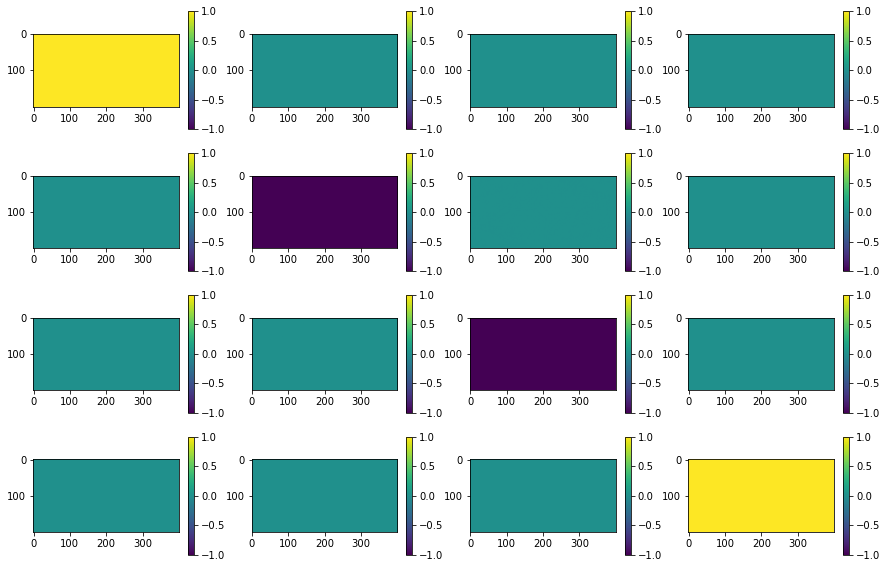

In [37]:
# compute the Stokes coordinate in the world coordinate
M_rot = rotate_stokes_basis(v_world, xx_world, xx_world_target)


plt.figure(figsize=(15,10))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1), plt.imshow(M_rot[:,i,j].reshape(R,C), vmin=-1, vmax=1), plt.colorbar()

# Testing 

In [42]:
w = torch.tensor([0., 0, 1]).reshape(1,3) # Optical axis / forward direction

s_00 = torch.tensor([1., 1, 0, 0]).reshape(4,1) # Horizontally polarized light
b_00 = stokes_basis(w) # Corresponding Stokes basis

def rotate(axis, theta):
    """
    https://stackoverflow.com/questions/6802577/rotation-of-3d-vector
    
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    theta = torch.deg2rad(torch.tensor(theta))
    axis = axis / torch.sqrt((axis*axis).sum(axis=-1))
    a = torch.cos(theta / 2.0)
    tmp = -axis * torch.sin(theta / 2.0)
    b, c, d = tmp[:,0], tmp[:,1], tmp[:,2]
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d

    return torch.tensor([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


def rotate_vector(v, axis, angle):
    rotmat = rotate(axis, angle)
    return ( rotmat @ v.T).T

# Switch to basis rotated by 90˚.
b_90 = rotate_vector(b_00, w, 90.0)
assert torch.allclose(b_90, torch.tensor([0., 1, 0]), atol=1e-3)

# Now polarization should be at 90˚ / vertical (with Stokes vector [1, -1, 0, 0])
s_90 = rotate_stokes_basis(w, b_00, b_90) @ s_00
assert torch.allclose(s_90, torch.tensor([1.0, -1.0, 0.0, 0.0]).reshape((4,1)), atol=1e-3)

# Switch to basis rotated by +45˚.
b_45 = rotate_vector(b_00, w, +45.0)
assert torch.allclose(b_45, torch.tensor([0.70712, 0.70712, 0.0]), atol=1e-3)
# Now polarization should be at -45˚ (with Stokes vector [1, 0, -1, 0])
s_45 = rotate_stokes_basis(w, b_00, b_45) @ s_00
assert torch.allclose(s_45, torch.tensor([1.0, 0.0, -1.0, 0.0]).reshape((4,1)), atol=1e-3)

# Switch to basis rotated by -45˚.
b_45_neg = rotate_vector(b_00, w, -45.0)
assert torch.allclose(b_45_neg, torch.tensor([0.70712, -0.70712, 0.0]), atol=1e-3)
# Now polarization should be at +45˚ (with Stokes vector [1, 0, +1, 0])
s_45_neg = rotate_stokes_basis(w, b_00, b_45_neg) @ s_00
assert torch.allclose(s_45_neg, torch.tensor([1.0, 0.0, +1.0, 0.0]).reshape((4,1)), atol=1e-3)

print('testing succeeded!')